In [1]:
from astropy.io.votable import parse
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.ndimage import uniform_filter1d

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, f1_score, accuracy_score, precision_score, recall_score
import seaborn as sns

数据加载和初步可视化

In [2]:
# load gaia catalog data and check its ICRS coordinates range
gaia_csv_path = r'D:\file\my file\SH9802CL98051001gaia_catalog.csv'
gaia_df = pd.read_csv(gaia_csv_path)
print("Gaia 星表列名:", gaia_df.columns)

ra_column = 'ra' 
dec_column = 'dec'  

ra_min = gaia_df[ra_column].min()
ra_max = gaia_df[ra_column].max()
dec_min = gaia_df[dec_column].min()
dec_max = gaia_df[dec_column].max()

print(f"赤经范围: {ra_min:.6f} 到 {ra_max:.6f} 度")
print(f"赤纬范围: {dec_min:.6f} 到 {dec_max:.6f} 度")

Gaia 星表列名: Index(['SOURCE_ID', 'ra', 'dec', 'phot_g_mean_mag', 'parallax', 'pmra',
       'pmdec'],
      dtype='object')
赤经范围: 14.909627 到 18.635074 度
赤纬范围: 61.721586 到 63.279274 度


In [2]:
import pandas as pd

# 读取 CSV 文件
df = pd.read_csv(r"D:\file\my file\SH9802CL98051001gaia_catalog.csv")

# 假设星等列名为 'mag'
count = (df['phot_g_mean_mag'] < 16).sum()

print(f"星等小于16的源共有 {count} 个")


星等小于16的源共有 8940 个


In [6]:
# load img data and SEx detected data
fits_path = r'D:\AI\images\SH9802CL98051001.fits'
sextractor_cat_path = r'D:\AI\test.cat'
output_csv_path = 'SH9802CL98051001_matched_catalog.csv'

with fits.open(fits_path) as hdul:
    header = hdul[0].header
    wcs = WCS(header)
    data = hdul[0].data

gaia_df['ra'] = pd.to_numeric(gaia_df['ra'], errors='coerce')
gaia_df['dec'] = pd.to_numeric(gaia_df['dec'], errors='coerce')

sextractor_df = pd.read_csv(sextractor_cat_path, sep='\s+', comment='#', header=None)

num_columns = len(sextractor_df.columns)
if num_columns == 3:
    sextractor_df.columns = ['FLUX', 'X_IMAGE', 'Y_IMAGE']
else:
    raise ValueError(f"未知的列数: {num_columns}")

print("SExtractor 探测到的源:")
print(sextractor_df.head())

NameError: name 'gaia_df' is not defined

In [7]:
# change SEx XY coords to sky coords
sextractor_coords = wcs.all_pix2world(sextractor_df[['X_IMAGE', 'Y_IMAGE']], 0)
sextractor_df['RA'] = sextractor_coords[:, 0]
sextractor_df['DEC'] = sextractor_coords[:, 1]
print("SExtractor 探测到的源的天球坐标:")
print(sextractor_df[['RA', 'DEC']].head())

NameError: name 'sextractor_df' is not defined

In [6]:
# match
gaia_coords = SkyCoord(ra=gaia_df['ra'].values * u.degree, dec=gaia_df['dec'].values * u.degree)
sextractor_coords = SkyCoord(ra=sextractor_df['RA'].values * u.degree, dec=sextractor_df['DEC'].values * u.degree)

max_separation = 8 * u.arcsec  # max sky coord distance set（5~10左右合适）

idx, d2d, _ = sextractor_coords.match_to_catalog_sky(gaia_coords)

sex_matched_mask = d2d < max_separation
sextractor_df['MATCHED'] = sex_matched_mask.astype(int)
sextractor_df['SEPARATION'] = d2d.arcsec


所有源（包括匹配成功和失败的）已保存到 SH9802CL98051001_matched_catalog.csv


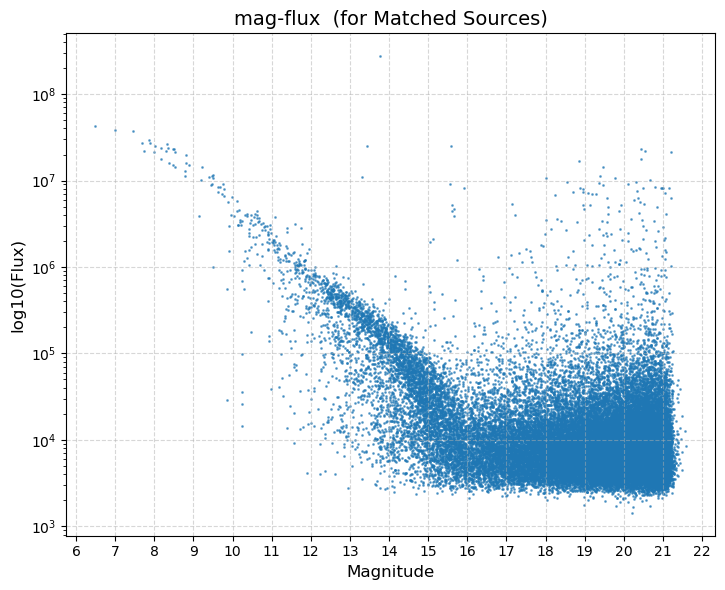

In [7]:
# add gaia mag to SEx catalog for successfully matched objects
if 'phot_g_mean_mag' in gaia_df.columns:
    sextractor_df['GAIA_MAG'] = np.nan
    sextractor_df.loc[sex_matched_mask, 'GAIA_MAG'] = gaia_df.iloc[idx[sex_matched_mask]]['phot_g_mean_mag'].values

sextractor_df.to_csv(output_csv_path, index=False)
print(f"\n所有源（包括匹配成功和失败的）已保存到 {output_csv_path}")

matched_sources = sextractor_df[sex_matched_mask]

# plot mag-flux fig for matched objects
if len(matched_sources) == 0:
    raise ValueError("匹配成功的源为空，无法绘制散点图。")

flux = matched_sources['FLUX'].values
gaia_mag = matched_sources['GAIA_MAG'].values

valid_mask = (~np.isnan(flux)) & (~np.isinf(flux)) & (flux > 0) & (~np.isnan(gaia_mag)) & (~np.isinf(gaia_mag))
flux = flux[valid_mask]
gaia_mag = gaia_mag[valid_mask]
# comment:: 不如保存匹配星表的时候就用这种有效样本来保存？

if len(valid_mask) == 0:
    raise ValueError("有效数据为空，无法绘制散点图。")
plt.figure(figsize=(14, 6))

# 星等与log10流量的关系
plt.subplot(122)
plt.scatter(gaia_mag, flux, alpha=0.6, s=1)  
plt.xlabel('Magnitude', fontsize=12)
plt.xticks(np.arange(6,23))
plt.ylabel('log10(Flux)', fontsize=12)
plt.yscale('log')  # comment:: 用yscale更好，有一个小刻度可以辅助更好的对比指数数量
plt.title('mag-flux  (for Matched Sources)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('./firstmatch_mag-flux.png')  # comment:: 如有必要，可以将图片保存下来，放在如media之类的文件夹中

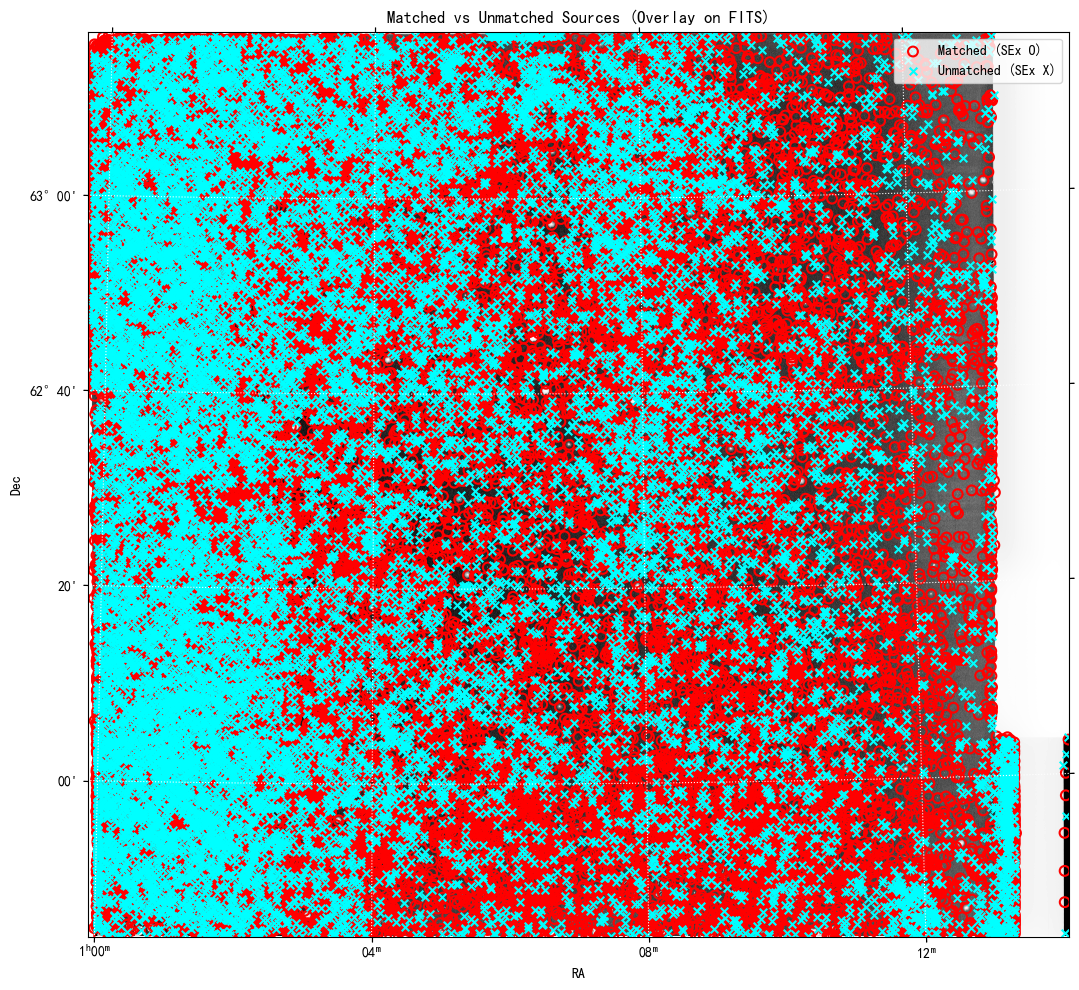

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置黑体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

# ---------- 文件路径 ----------
fits_path = r'D:\AI\images\SH9802CL98051001.fits'
matched_csv = r'D:\github\Work\STUDY\SH9802CL98051001_matched_catalog.csv'  # 包含 SExtractor + 匹配 ra, dec 等的 csv

# ---------- 读取 FITS 图像和 WCS ----------
with fits.open(fits_path) as hdul:
    data = hdul[0].data
    wcs = WCS(hdul[0].header)

# ---------- 读取匹配结果 ----------
df = pd.read_csv(matched_csv)

# ---------- 分离匹配成功和失败的源 ----------
matched_df = df[df['MATCHED'] == 1]
unmatched_df = df[df['MATCHED'] == 0]

# ---------- 绘图 ----------
fig = plt.figure(figsize=(12, 10))
ax = plt.subplot(projection=wcs)
ax.imshow(data, cmap='gray', origin='lower', vmin=np.percentile(data, 5), vmax=np.percentile(data, 99.5))
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_title('Matched vs Unmatched Sources (Overlay on FITS)')

# ---------- 绘制 SExtractor 检测源 ----------
sex_ra_matched, sex_dec_matched = matched_df['RA'], matched_df['DEC']
sex_ra_unmatched, sex_dec_unmatched = unmatched_df['RA'], unmatched_df['DEC']

# 已匹配的红圈
ax.scatter(sex_ra_matched, sex_dec_matched, transform=ax.get_transform('world'), 
           s=50, edgecolor='red', facecolor='none', linewidth=1.5, label='Matched (SEx O)')
# 未匹配的蓝叉
ax.scatter(sex_ra_unmatched, sex_dec_unmatched, transform=ax.get_transform('world'), 
           s=30, color='cyan', marker='x', label='Unmatched (SEx X)')

# 可选：绘制 Gaia 源的位置（若你想补充显示）
# ax.scatter(df['gaia_ra'], df['gaia_dec'], transform=ax.get_transform('world'), 
#            s=20, color='yellow', alpha=0.3, label='Gaia')

# ---------- 图例与显示 ----------
ax.legend(loc='upper right')
plt.grid(color='white', ls='dotted')
plt.tight_layout()
plt.show()


以下是一个简单的测试参数的示例，用于测试不同的匹配最大距离对匹配数量和有效匹配星等-流量分布图的影响：

有效匹配数（ms=3.00 arcsec）: 12355
有效匹配数（ms=4.09 arcsec）: 17912
有效匹配数（ms=5.18 arcsec）: 24051
有效匹配数（ms=6.27 arcsec）: 30382
有效匹配数（ms=7.36 arcsec）: 36307
有效匹配数（ms=8.45 arcsec）: 41550
有效匹配数（ms=9.55 arcsec）: 45831
有效匹配数（ms=10.64 arcsec）: 49235
有效匹配数（ms=11.73 arcsec）: 51869
有效匹配数（ms=12.82 arcsec）: 53721
有效匹配数（ms=13.91 arcsec）: 55014
有效匹配数（ms=15.00 arcsec）: 55837


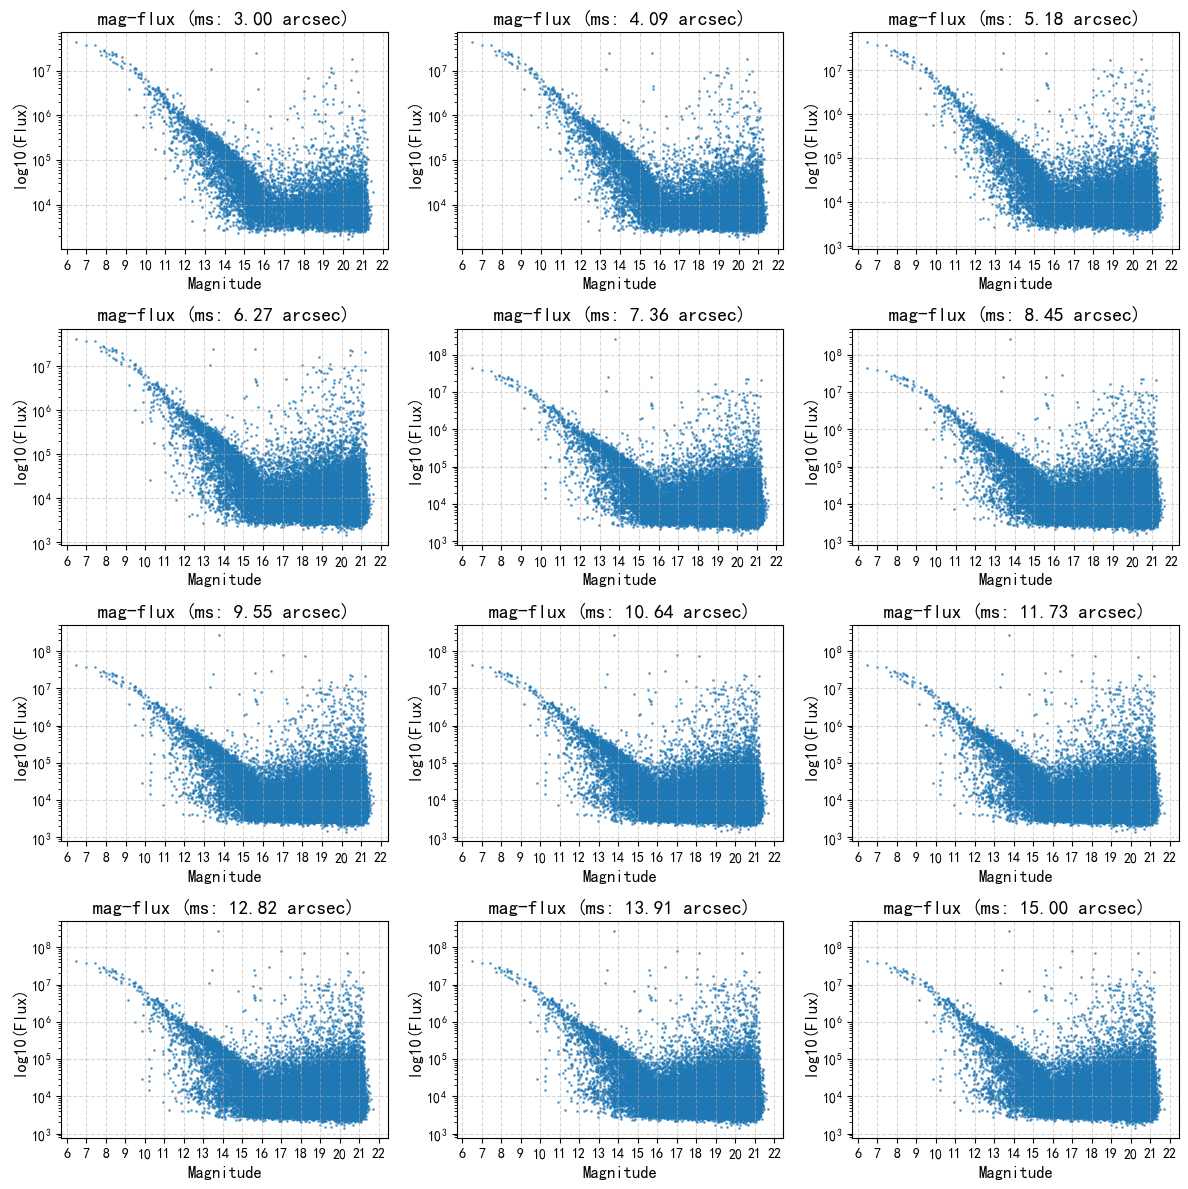

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from math import ceil

def test_max_separation(max_separation_list):
    num_plots = len(max_separation_list)
    fig_width = 3
    fig_height = ceil(num_plots / fig_width)
    
    if fig_height == 1 and fig_width == 1:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))
    else:
        fig, axes = plt.subplots(nrows=fig_height, ncols=fig_width, figsize=(fig_width*4, fig_height*3))
    
    axes = axes.flatten()
    
    for id, max_sep in enumerate(max_separation_list):
        max_separation = max_sep.to(u.degree)
        
        gaia_coords = SkyCoord(ra=gaia_df['ra'].values * u.degree, dec=gaia_df['dec'].values * u.degree)
        sextractor_coords = SkyCoord(ra=sextractor_df['RA'].values * u.degree, dec=sextractor_df['DEC'].values * u.degree)
        idx, d2d, _ = sextractor_coords.match_to_catalog_sky(gaia_coords)
        
        sex_matched_mask = d2d < max_separation
        flux = sextractor_df['FLUX'].values[sex_matched_mask]
        gaia_mag = gaia_df.iloc[idx, :]['phot_g_mean_mag'].values[sex_matched_mask]
        
        valid_mask = (
            ~np.isnan(flux) & ~np.isinf(flux) & (flux > 0) &
            ~np.isnan(gaia_mag) & ~np.isinf(gaia_mag)
        )
        flux = flux[valid_mask]
        gaia_mag = gaia_mag[valid_mask]
        
        if valid_mask.sum() == 0:
            raise ValueError("有效数据为空，无法绘制散点图。")
        else:
            print(f"有效匹配数（ms={max_sep.value:.2f} arcsec）: {valid_mask.sum()}")
        
        ax = axes[id]
        ax.scatter(gaia_mag, flux, alpha=0.6, s=1)
        ax.set_xlabel('Magnitude', fontsize=12)
        ax.set_xticks(np.arange(6, 23))
        ax.set_ylabel('log10(Flux)', fontsize=12)
        ax.set_yscale('log')
        ax.set_title(f'mag-flux (ms: {max_sep.value:.2f} arcsec)', fontsize=14)
        ax.grid(True, linestyle='--', alpha=0.5)
    
    fig.tight_layout()  
    return fig, axes

max_separation_list = np.linspace(3, 15, 12) * u.arcsec
fig, axes = test_max_separation(max_separation_list)
plt.show()

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.ndimage import uniform_filter1d

output_csv_path = 'SH9802CL98051001_matched_catalog.csv'
sextractor_df = pd.read_csv(output_csv_path)

matched_sources = sextractor_df[sextractor_df['MATCHED'] == 1]
flux = matched_sources['FLUX'].values
mag = matched_sources['GAIA_MAG'].values

valid = (~np.isnan(flux)) & (~np.isinf(flux)) & (flux > 0) & (~np.isnan(mag))
flux = flux[valid]
mag = mag[valid]

lower_mag = 6
upper_mag = 16
selected = (mag >= lower_mag) & (mag <= upper_mag)
mag_range = mag[selected]
log_flux_range = np.log10(flux[selected])

print(f"选定星等范围: {lower_mag:.1f} 到 {upper_mag:.1f} mag，共 {len(mag_range)} 个点")

选定星等范围: 6.0 到 16.0 mag，共 5556 个点


第1轮拟合：剔除 51 个异常点，剩余 5505 个点
第2轮拟合：剔除 27 个异常点，剩余 5478 个点
第3轮拟合：剔除 13 个异常点，剩余 5465 个点


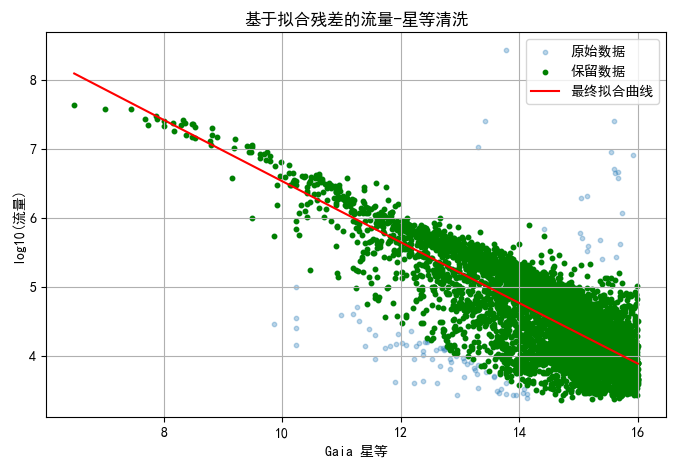

In [14]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置黑体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号


# 初始数据
sort_idx = np.argsort(mag_range)
mag_sorted = mag_range[sort_idx]
log_flux_sorted = log_flux_range[sort_idx]

# 拟合模型：多项式（如二次函数）
deg = 2
max_iter = 3
sigma_thresh = 3

# 初始化
mag_clean = mag_sorted.copy()
log_flux_clean = log_flux_sorted.copy()

for i in range(max_iter):
    # 拟合
    coeffs = np.polyfit(mag_clean, log_flux_clean, deg)
    model = np.poly1d(coeffs)
    pred = model(mag_clean)
    
    # 计算残差
    residuals = log_flux_clean - pred
    std = np.std(residuals)
    
    # 筛选
    keep_idx = np.abs(residuals) < sigma_thresh * std
    num_removed = np.sum(~keep_idx)
    
    # 更新数据
    mag_clean = mag_clean[keep_idx]
    log_flux_clean = log_flux_clean[keep_idx]
    
    print(f"第{i+1}轮拟合：剔除 {num_removed} 个异常点，剩余 {len(mag_clean)} 个点")
    if num_removed == 0:
        break  # 收敛

# 可选：绘图查看效果
plt.figure(figsize=(8, 5))
plt.scatter(mag_sorted, log_flux_sorted, s=10, alpha=0.3, label='原始数据')
plt.scatter(mag_clean, log_flux_clean, s=10, color='green', label='保留数据')
x_fit = np.linspace(mag_clean.min(), mag_clean.max(), 500)
plt.plot(x_fit, model(x_fit), 'r-', label='最终拟合曲线')
plt.xlabel("Gaia 星等")
plt.ylabel("log10(流量)")
plt.legend()
plt.title("基于拟合残差的流量-星等清洗")
plt.grid(True)
plt.show()


In [15]:
def linear_func(x, a, b):
    """线性函数：y = a*x + b"""
    return a * x + b

def quadratic_func(x, a, b, c):
    """二次函数：y = a*x² + b*x + c"""
    return a * x**2 + b * x + c

In [16]:
def total_residual_error(split_val):
    mask1 = mag_clean <= split_val
    mask2 = mag_clean > split_val
    if sum(mask1) < 3 or sum(mask2) < 5:
        return np.inf
    try:
        p1, _ = curve_fit(linear_func, mag_clean[mask1], log_flux_clean[mask1])
        p2, _ = curve_fit(quadratic_func, mag_clean[mask2], log_flux_clean[mask2])
        err1 = np.sum((log_flux_clean[mask1] - linear_func(mag_clean[mask1], *p1))**2)
        err2 = np.sum((log_flux_clean[mask2] - quadratic_func(mag_clean[mask2], *p2))**2)
        return err1 + err2
    except:
        return np.inf

search_range = np.linspace(lower_mag + 0.5, upper_mag - 1.5, 50)
split_point = min(search_range, key=total_residual_error)
print(f"最优分段点: {split_point:.2f} mag")

最优分段点: 14.34 mag


拟合结果:
亮星段: log10(flux) = -0.4436 * mag + 10.9802
暗星段: log10(flux) = 0.1168 * mag² + -3.9937 * mag + 37.9420


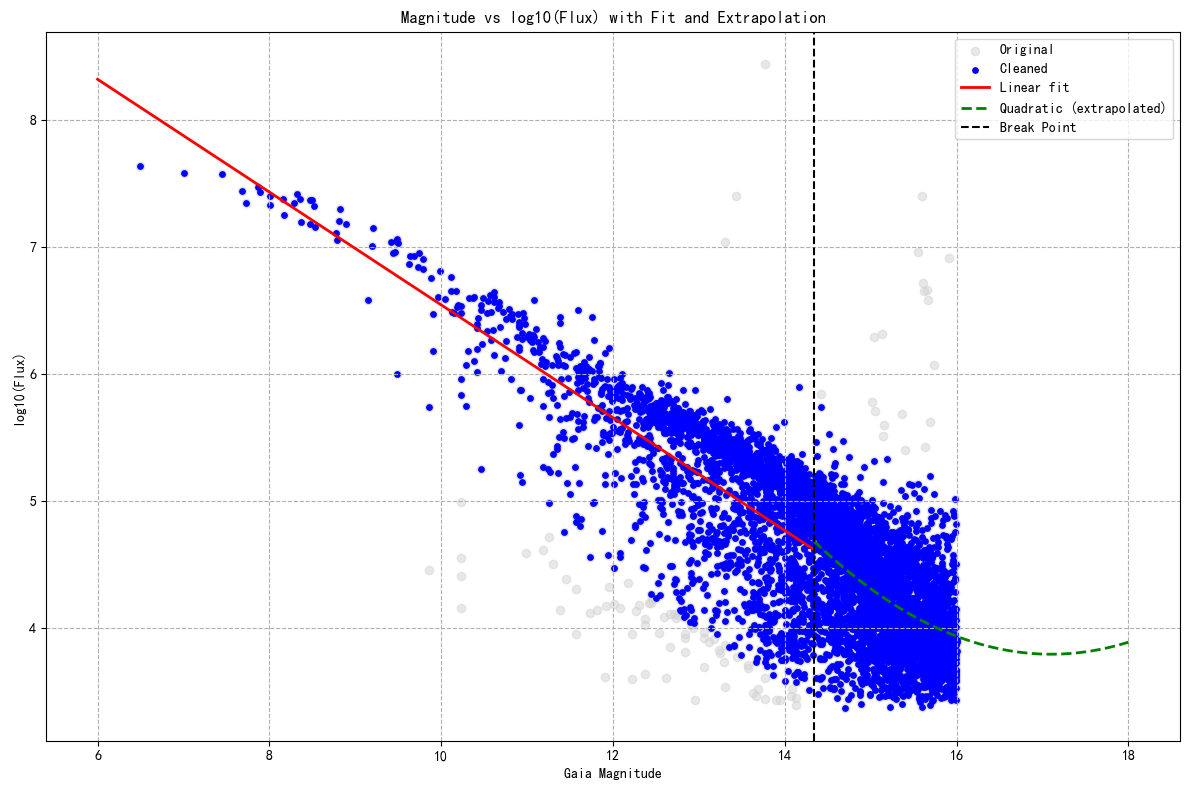

In [17]:
mask1 = mag_clean <= split_point
mask2 = mag_clean > split_point

popt1, _ = curve_fit(linear_func, mag_clean[mask1], log_flux_clean[mask1])
popt2, _ = curve_fit(quadratic_func, mag_clean[mask2], log_flux_clean[mask2])

print("拟合结果:")
print(f"亮星段: log10(flux) = {popt1[0]:.4f} * mag + {popt1[1]:.4f}")
print(f"暗星段: log10(flux) = {popt2[0]:.4f} * mag² + {popt2[1]:.4f} * mag + {popt2[2]:.4f}")

plt.figure(figsize=(12, 8))
plt.scatter(mag_range, log_flux_range, c='lightgray', alpha=0.5, label='Original')
plt.scatter(mag_clean, log_flux_clean, c='blue', s=15, label='Cleaned')

x_fit1 = np.linspace(lower_mag, split_point, 100)
x_fit2 = np.linspace(split_point, upper_mag + 2, 100)
plt.plot(x_fit1, linear_func(x_fit1, *popt1), 'r-', lw=2, label='Linear fit')
plt.plot(x_fit2, quadratic_func(x_fit2, *popt2), 'g--', lw=2, label='Quadratic (extrapolated)')

plt.axvline(split_point, color='k', linestyle='--', label='Break Point')
plt.xlabel('Gaia Magnitude')
plt.ylabel('log10(Flux)')
plt.title('Magnitude vs log10(Flux) with Fit and Extrapolation')
plt.legend()
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.show()


In [18]:
import pandas as pd
import numpy as np

# 假设这是之前拟合得到的最优分段点与拟合参数
popt1 = [-0.4494, 11.0554]              # 亮星段线性拟合参数
popt2 = [0.0987, -3.4403, 33.7037]     # 暗星段二次拟合参数
split_point = 14.26                   # 自动搜索出的最优分段点

# 拟合函数定义（用于正向计算）
def linear_func(x, a, b):
    return a * x + b

# 逆解函数
def inverse_mag_from_log_flux(log_flux_val, popt1, popt2, split_point):
    try:
        log_flux_split = linear_func(split_point, *popt1)
        if log_flux_val >= log_flux_split:
            a, b = popt1
            return (log_flux_val - b) / a if abs(a) > 1e-8 else np.nan
        else:
            a, b, c = popt2
            A, B, C = a, b, c - log_flux_val
            if abs(A) < 1e-8:
                return -C / B if B != 0 else np.nan
            delta = B**2 - 4*A*C
            if delta < 0:
                return np.nan
            sqrt_delta = np.sqrt(delta)
            x1 = (-B + sqrt_delta) / (2*A)
            x2 = (-B - sqrt_delta) / (2*A)
            return x1 if abs(x1 - split_point) < abs(x2 - split_point) else x2
    except Exception as e:
        print(f"逆解失败：log_flux = {log_flux_val}, 错误信息: {e}")
        return np.nan

# 读取 .cat 文件
test_df = pd.read_csv(
    r"D:\AI\test.cat",     # 请替换为你的原始 .cat 文件路径
    sep=r'\s+',
    comment='#',
    header=None,
    names=["FLUX_ISO", "X_IMAGE", "Y_IMAGE"]
)

# 只保留正流量数据并计算 log10(flux)
test_df = test_df[test_df["FLUX_ISO"] > 0].copy()
test_df["log_flux"] = np.log10(test_df["FLUX_ISO"])

# 应用逆解函数，计算星等
test_df["GAIA_MAG_EST"] = test_df["log_flux"].apply(
    lambda x: inverse_mag_from_log_flux(x, popt1, popt2, split_point)
)

# 打印调试信息
print(test_df[["log_flux", "GAIA_MAG_EST"]].head())
print("写入前共有行：", len(test_df))
print("含 NaN 的 GAIA_MAG_EST 个数：", test_df["GAIA_MAG_EST"].isna().sum())

# 保存输出文件（格式：GAIA_MAG_EST FLUX_ISO X_IMAGE Y_IMAGE）
output_path = r"D:\github\Work\STUDY\test_with_mag.cat"  # 请根据需要更改路径
test_df[["GAIA_MAG_EST", "FLUX_ISO", "X_IMAGE", "Y_IMAGE"]].to_csv(
    output_path, sep="\t", index=False, header=False
)

print(f"估计完成，共处理 {len(test_df)} 个目标，结果保存为：{output_path}")


   log_flux  GAIA_MAG_EST
0  3.439356           NaN
1  4.079808      15.53157
2  3.530948           NaN
3  3.558913           NaN
4  3.579861           NaN
写入前共有行： 57230
含 NaN 的 GAIA_MAG_EST 个数： 14483
估计完成，共处理 57230 个目标，结果保存为：D:\github\Work\STUDY\test_with_mag.cat


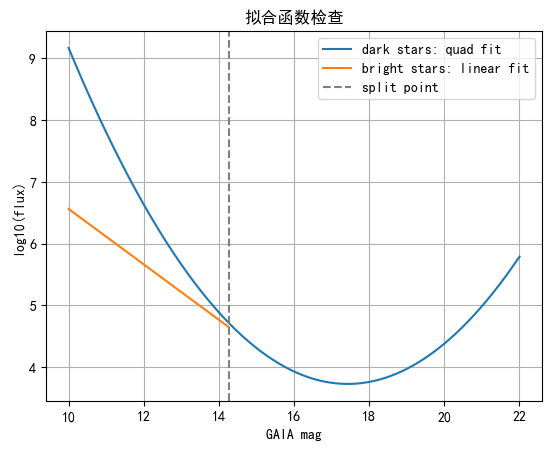

In [19]:
import matplotlib.pyplot as plt

x = np.linspace(10, 22, 300)
y1 = popt1[0] * x + popt1[1]
y2 = popt2[0] * x**2 + popt2[1] * x + popt2[2]

plt.plot(x, y2, label='dark stars: quad fit')
plt.plot(x[x <= split_point], y1[x <= split_point], label='bright stars: linear fit')
plt.axvline(split_point, linestyle='--', color='gray', label='split point')
plt.xlabel('GAIA mag')
plt.ylabel('log10(flux)')
plt.legend()
plt.grid(True)
plt.title("拟合函数检查")
plt.show()


In [20]:
import pandas as pd
import numpy as np

# 假设这是之前拟合得到的最优分段点与拟合参数
popt1 = [-0.4494, 11.0554]              # 亮星段线性拟合参数
popt2 = [0.0987, -3.4403, 33.7037]     # 暗星段二次拟合参数
split_point = 14.26                   # 自动搜索出的最优分段点

# 分界点对应的 log_flux 值
log_flux_split = popt1[0] * split_point + popt1[1]

# 读取 .cat 文件
test_df = pd.read_csv(
    r"D:\AI\test.cat",
    sep=r'\s+',
    comment='#',
    header=None,
    names=["FLUX_ISO", "X_IMAGE", "Y_IMAGE"]
)

# 保留正流量
test_df = test_df[test_df["FLUX_ISO"] > 0].copy()
test_df["log_flux"] = np.log10(test_df["FLUX_ISO"])

# 逆解函数
def inverse_mag(log_flux_val):
    try:
        if log_flux_val >= log_flux_split:
            # 使用线性逆解
            a, b = popt1
            return (log_flux_val - b) / a
        else:
            # 使用二次逆解
            a, b, c = popt2
            A, B, C = a, b, c - log_flux_val

            if abs(A) < 1e-8:
                return -C / B if B != 0 else np.nan

            delta = B**2 - 4*A*C
            if delta < 0:
                return np.nan

            sqrt_delta = np.sqrt(delta)
            x1 = (-B + sqrt_delta) / (2*A)
            x2 = (-B - sqrt_delta) / (2*A)

            return x1 if abs(x1 - split_point) < abs(x2 - split_point) else x2

    except Exception as e:
        print(f"逆解失败：log_flux = {log_flux_val}, 错误信息: {e}")
        return np.nan

# 应用逆解函数
test_df["GAIA_MAG_EST"] = test_df["log_flux"].apply(inverse_mag)

# 输出调试信息
print(test_df[["log_flux", "GAIA_MAG_EST"]].head(10))
print("写入前共有行：", len(test_df))
print("含 NaN 的 GAIA_MAG_EST 个数：", test_df["GAIA_MAG_EST"].isna().sum())

# 保存输出
output_path = r"D:\github\Work\STUDY\test_with_mag.cat"
test_df[["GAIA_MAG_EST", "FLUX_ISO", "X_IMAGE", "Y_IMAGE"]].to_csv(
    output_path, sep="\t", index=False, header=False
)
print(f"估计完成，共处理 {len(test_df)} 个目标，结果保存为：{output_path}")


   log_flux  GAIA_MAG_EST
0  3.439356           NaN
1  4.079808     15.531570
2  3.530948           NaN
3  3.558913           NaN
4  3.579861           NaN
5  3.540841           NaN
6  3.874700     16.195750
7  3.637659           NaN
8  3.978055     15.826267
9  3.776483     16.704540
写入前共有行： 57230
含 NaN 的 GAIA_MAG_EST 个数： 14483
估计完成，共处理 57230 个目标，结果保存为：D:\github\Work\STUDY\test_with_mag.cat


In [33]:
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.wcs import WCS
from scipy.spatial import cKDTree

# 读取.cat文件，注意列名对应
cat_path = r"D:\github\Work\STUDY\test_with_mag.cat"
cat_df = pd.read_csv(cat_path, sep='\t', names=["GAIA_MAG_EST", "FLUX_ISO", "X_IMAGE", "Y_IMAGE"])

# 读取Gaia星表，假设CSV格式，包含 ra, dec, phot_g_mean_mag
gaia_path = r"D:\file\my file\SH9802CL98051001gaia_catalog.csv"
gaia_df = pd.read_csv(gaia_path)

# 读取fits文件，获取WCS
fits_path = r"D:\AI\images\SH9802CL98051001.fits"
with fits.open(fits_path) as hdul:
    wcs = WCS(hdul[0].header)

# 将Gaia星表的天球坐标转换为图像像素坐标
world_coords = np.vstack([gaia_df['ra'].values, gaia_df['dec'].values]).T
x_pix, y_pix = wcs.world_to_pixel_values(world_coords[:, 0], world_coords[:, 1])
gaia_df['X'] = x_pix
gaia_df['Y'] = y_pix
gaia_df['MAG'] = gaia_df['phot_g_mean_mag']

def weighted_3d_match_by_estimated_mag(sextractor_df, gaia_df, alpha=1, beta=3, threshold=8.0):
    sextractor_df = sextractor_df.copy()
    sextractor_df['XYM_MATCHED'] = 0
    # 初始化新增列，默认空值
    sextractor_df['GAIA_RA'] = np.nan
    sextractor_df['GAIA_DEC'] = np.nan
    sextractor_df['GAIA_MAG'] = np.nan

    # 过滤无效数据
    valid_s = sextractor_df[['X_IMAGE', 'Y_IMAGE', 'GAIA_MAG_EST']].dropna()
    valid_g = gaia_df[['X', 'Y', 'MAG', 'ra', 'dec']].dropna()

    if valid_s.empty or valid_g.empty:
        print("三维匹配失败：无有效源")
        return sextractor_df

    sex_coords = np.vstack([
        alpha * valid_s['X_IMAGE'].values,
        alpha * valid_s['Y_IMAGE'].values,
        beta * valid_s['GAIA_MAG_EST'].values
    ]).T

    gaia_coords = np.vstack([
        alpha * valid_g['X'].values,
        alpha * valid_g['Y'].values,
        beta * valid_g['MAG'].values
    ]).T

    tree = cKDTree(gaia_coords)
    distances, indices = tree.query(sex_coords, distance_upper_bound=threshold)

    matched_indices = valid_s.index.to_numpy()
    for i, (dist, idx) in enumerate(zip(distances, indices)):
        if idx != len(valid_g) and np.isfinite(dist):
            sextractor_df.at[matched_indices[i], 'XYM_MATCHED'] = 1
            # 填入匹配的Gaia星表信息
            sextractor_df.at[matched_indices[i], 'GAIA_RA'] = valid_g.iloc[idx]['ra']
            sextractor_df.at[matched_indices[i], 'GAIA_DEC'] = valid_g.iloc[idx]['dec']
            sextractor_df.at[matched_indices[i], 'GAIA_MAG'] = valid_g.iloc[idx]['MAG']

    print(f"三维匹配完成：成功匹配 {sextractor_df['XYM_MATCHED'].sum()} 个源")
    return sextractor_df

# 执行匹配
result_df = weighted_3d_match_by_estimated_mag(cat_df, gaia_df)

# 保存匹配结果为CSV
output_path = "test_matched.csv"
result_df.to_csv(output_path, index=False)
print(f"匹配结果已保存至: {output_path}")


三维匹配完成：成功匹配 4783 个源
匹配结果已保存至: test_matched.csv


In [34]:
plt.rcParams['font.family'] = 'SimHei'

fits_image = fits.open(r'D:\AI\images\SH9802CL98051001.fits')
data = fits_image[0].data

okok_df = pd.read_csv(r'D:\github\Work\STUDY\test_matched.csv')

okok_df_cleaned = okok_df.dropna(subset=['GAIA_MAG'])

print("\n=== 清洗后的数据 ===")
print(okok_df_cleaned.describe())

valid_samples = okok_df_cleaned[okok_df_cleaned['GAIA_MAG'] >= 0]

print(f"有效样本数: {valid_samples.shape[0]}")

if valid_samples.shape[0] == 0:
    print("没有有效的样本，请检查筛选条件。")
else:
    min_mag = valid_samples['GAIA_MAG'].min()
    max_mag = valid_samples['GAIA_MAG'].max()
    print(f"最小星等: {min_mag}, 最大星等: {max_mag}")


=== 清洗后的数据 ===
       GAIA_MAG_EST      FLUX_ISO       X_IMAGE       Y_IMAGE  XYM_MATCHED  \
count   4783.000000  4.783000e+03   4783.000000   4783.000000       4783.0   
mean      14.187827  3.034796e+05   8110.153939   8816.813481          1.0   
std        1.560903  1.765072e+06   5290.459412   5777.751342          0.0   
min        7.727766  5.306812e+03    100.223600      6.385900          1.0   
25%       13.168436  1.461119e+04   3317.526600   3069.102050          1.0   
50%       14.388287  4.333382e+04   7620.505900   8708.807600          1.0   
75%       15.316987  1.372476e+05  12533.872100  14136.332500          1.0   
max       17.414030  3.824212e+07  19008.310500  18524.492200          1.0   

           GAIA_RA     GAIA_DEC     GAIA_MAG  
count  4783.000000  4783.000000  4783.000000  
mean     16.402578    62.469143    14.543377  
std       0.950699     0.480493     1.604933  
min      14.934286    61.726974     7.000399  
25%      15.539625    61.990569    13.682605  

In [36]:
def generate_ds9_reg(csv_path, reg_path, radius=5):
    """
    根据匹配CSV文件生成DS9区域文件，仅包含匹配成功的天体。
    
    参数：
    - csv_path: 匹配结果CSV文件路径
    - reg_path: 输出的DS9区域文件路径
    - radius: 圆圈半径，单位为像素，默认5
    """
    import pandas as pd

    df = pd.read_csv(csv_path)

    # 过滤匹配成功的条目
    matched = df[df['XYM_MATCHED'] == 1]

    with open(reg_path, 'w') as f:
        # 写入DS9区域文件头
        f.write('# Region file format: DS9 version 4.1\n')
        f.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
        f.write('image\n')

        # 写入每个匹配点的圆形区域，格式: circle(x, y, radius)
        for _, row in matched.iterrows():
            x = row['X_IMAGE']
            y = row['Y_IMAGE']
            f.write(f'circle({x:.2f},{y:.2f},{radius})\n')

    print(f"DS9区域文件已生成: {reg_path}")

# 示例调用
csv_file = r"D:\github\Work\STUDY\test_matched.csv"
reg_file = "matched_sources.reg"
generate_ds9_reg(csv_file, reg_file)


DS9区域文件已生成: matched_sources.reg


In [54]:
import pandas as pd

# 输入文件路径（SExtractor输出星表）
input_file = r'D:\github\Work\STUDY\test_matched.csv'  # 可为 .cat 转换为 csv 后读取

# 输出的 DS9 区域文件
output_file = 'sex_regions.reg'

# 读取星表（确保包含 X_IMAGE 与 Y_IMAGE 字段）
df = pd.read_csv(input_file)

# 开始构建 DS9 region 文件
with open(output_file, 'w') as f:
    # DS9 region 文件头
    f.write('# Region file format: DS9 version 4.1\n')
    f.write('global color=green font="helvetica 10 normal" select=1 edit=1 move=1 delete=1 include=1 fixed=0\n')
    f.write('image\n')

    # 每一行写一个圆形区域，中心为 (X_IMAGE, Y_IMAGE)，半径5像素
    for _, row in df.iterrows():
        x = row['X_IMAGE']
        y = row['Y_IMAGE']
        f.write(f'circle({x:.2f},{y:.2f},5)\n')


In [58]:
import pandas as pd

# 文件路径
input_file = r'D:\github\Work\STUDY\test_with_mag.cat'
output_file = 'sorted_by_Y1.cat'

# 明确指定字段名（3列）
col_names = ['Gaia_mag', 'FLUX_ISO', 'X_IMAGE', 'Y_IMAGE']

# 读取数据，跳过以 # 开头的注释行，指定列名
df = pd.read_csv(input_file, delim_whitespace=True, comment='#', names=col_names)

# 按 Y_IMAGE 升序排序
df_sorted = df.sort_values(by='Y_IMAGE', ascending=True)

# 保存排序结果
df_sorted.to_csv(output_file, sep=' ', index=False)


C:\Users\mapleLWG\AppData\Local\Temp\ipykernel_28032\3231042233.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(input_file, delim_whitespace=True, comment='#', names=col_names)


In [43]:
import numpy as np
import pandas as pd
from astropy.io import fits

# ------------------ 参数设置 ------------------
patch_size = 32
fits_path = r"D:\AI\images\SH9802CL98051001.fits"
matched_csv_path = r"D:\github\Work\STUDY\test_matched.csv"

# ------------------ 打开 FITS 图像 ------------------
with fits.open(fits_path) as hdul:
    data = hdul[0].data.astype(np.float32)

# 估计背景（用于归一化）
estimated_background = np.median(data)

# ------------------ 读取匹配数据 ------------------
df = pd.read_csv(matched_csv_path)
df = df.dropna(subset=['X_IMAGE', 'Y_IMAGE', 'XYM_MATCHED'])  # 去除无效位置

# ------------------ 准备裁剪 ------------------
patches = []
raw_patches = []
valid_labels = []

center_threshold = 0.5  # 控制中心严格在中间
half_size = patch_size // 2

for _, row in df.iterrows():
    x, y = int(round(row['X_IMAGE'])), int(round(row['Y_IMAGE']))
    label = int(row['XYM_MATCHED'])

    x_min, x_max = x - half_size, x + half_size
    y_min, y_max = y - half_size, y + half_size

    # 边界检查
    if x_min >= 0 and x_max < data.shape[1] and y_min >= 0 and y_max < data.shape[0]:
        x_offset = x - x_min
        y_offset = y - y_min
        if abs(x_offset - half_size) <= center_threshold and abs(y_offset - half_size) <= center_threshold:
            patch = data[y_min:y_max, x_min:x_max]
            raw_patches.append(patch.copy())

            # 归一化 patch
            patch = patch - estimated_background
            patch = np.log10(np.clip(patch, 1, None))  # 避免负数
            patches.append(patch)
            valid_labels.append(label)

# ------------------ 转为 NumPy ------------------
patches = np.array(patches)
raw_patches = np.array(raw_patches)
valid_labels = np.array(valid_labels)

# ------------------ 输出信息 ------------------
print(f"共提取 patch 数量：{len(patches)}")
print(f"匹配成功（正样本）数量：{np.sum(valid_labels == 1)}")
print(f"未匹配（负样本）数量：{np.sum(valid_labels == 0)}")


共提取 patch 数量：57129
匹配成功（正样本）数量：4780
未匹配（负样本）数量：52349


In [44]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive, HBox, VBox, Output
import numpy as np
from IPython.display import display, clear_output

class PatchViewer:
    def __init__(self, raw_patches, valid_labels, patches=None):
        self.raw_patches = raw_patches
        self.valid_labels = valid_labels
        self.patches = patches  # 预处理后的patches（可选）
        self.total_patches = len(raw_patches)
        self.pos_indices = np.where(valid_labels == 1)[0]
        self.neg_indices = np.where(valid_labels == 0)[0]
        
        # 统计信息
        self.stats = {
            'total': self.total_patches,
            'positive': len(self.pos_indices),
            'negative': len(self.neg_indices),
            'pos_ratio': len(self.pos_indices) / self.total_patches
        }
        
        self.setup_widgets()
    
    def setup_widgets(self):
        """设置交互组件"""
        # 基本控制
        self.slider_startid = widgets.IntSlider(
            value=0, min=0, max=max(0, self.total_patches - 1), 
            step=1, description='起始ID:', style={'description_width': '80px'}
        )
        
        self.slider_ncols = widgets.IntSlider(
            value=4, min=1, max=8, step=1, 
            description='列数:', style={'description_width': '80px'}
        )
        
        self.slider_nrows = widgets.IntSlider(
            value=3, min=1, max=8, step=1,
            description='行数:', style={'description_width': '80px'}
        )
        
        # 显示模式选择
        self.mode_dropdown = widgets.Dropdown(
            options=[('全部样本', 'all'), ('仅正样本', 'positive'), ('仅负样本', 'negative')],
            value='all', description='显示模式:', style={'description_width': '80px'}
        )
        
        # 图像类型选择
        self.image_type = widgets.Dropdown(
            options=[('原始图像', 'raw'), ('预处理图像', 'processed')] if self.patches is not None else [('原始图像', 'raw')],
            value='raw', description='图像类型:', style={'description_width': '80px'}
        )
        
        # 颜色映射选择
        self.colormap = widgets.Dropdown(
            options=['gray', 'viridis', 'plasma', 'inferno', 'hot', 'cool'],
            value='gray', description='颜色映射:', style={'description_width': '80px'}
        )
        
        # 快速跳转按钮
        self.btn_first = widgets.Button(description="首页", button_style='info')
        self.btn_prev = widgets.Button(description="上一页", button_style='primary')
        self.btn_next = widgets.Button(description="下一页", button_style='primary')
        self.btn_last = widgets.Button(description="末页", button_style='info')
        self.btn_random = widgets.Button(description="随机", button_style='warning')
        
        # 绑定事件
        self.btn_first.on_click(lambda b: self.jump_to_page('first'))
        self.btn_prev.on_click(lambda b: self.jump_to_page('prev'))
        self.btn_next.on_click(lambda b: self.jump_to_page('next'))
        self.btn_last.on_click(lambda b: self.jump_to_page('last'))
        self.btn_random.on_click(lambda b: self.jump_to_page('random'))
        
        # 统计信息显示
        self.stats_output = widgets.HTML(value=self.get_stats_html())
        
        # 输出区域
        self.plot_output = Output()
    
    def get_stats_html(self):
        """生成统计信息HTML"""
        return f"""
        <div style="padding: 10px; background-color: #f0f0f0; border-radius: 5px;">
            <h4>数据统计</h4>
            <p><b>总数量:</b> {self.stats['total']}</p>
            <p><b>正样本:</b> {self.stats['positive']} ({self.stats['pos_ratio']:.1%})</p>
            <p><b>负样本:</b> {self.stats['negative']} ({1-self.stats['pos_ratio']:.1%})</p>
        </div>
        """
    
    def get_current_data(self):
        """根据显示模式获取当前数据"""
        mode = self.mode_dropdown.value
        if mode == 'positive':
            return self.raw_patches[self.pos_indices], self.valid_labels[self.pos_indices], self.pos_indices
        elif mode == 'negative':
            return self.raw_patches[self.neg_indices], self.valid_labels[self.neg_indices], self.neg_indices
        else:
            return self.raw_patches, self.valid_labels, np.arange(len(self.raw_patches))
    
    def jump_to_page(self, direction):
        """页面跳转"""
        current_patches, _, _ = self.get_current_data()
        total = len(current_patches)
        page_size = self.slider_ncols.value * self.slider_nrows.value
        
        if direction == 'first':
            self.slider_startid.value = 0
        elif direction == 'last':
            self.slider_startid.value = max(0, total - page_size)
        elif direction == 'prev':
            self.slider_startid.value = max(0, self.slider_startid.value - page_size)
        elif direction == 'next':
            self.slider_startid.value = min(total - 1, self.slider_startid.value + page_size)
        elif direction == 'random':
            self.slider_startid.value = np.random.randint(0, max(1, total - page_size + 1))
    
    def check_dataset(self, startid=0, ncols=4, nrows=3, mode='all', image_type='raw', colormap='gray'):
        """主要的可视化函数"""
        # 获取当前模式的数据
        current_patches, current_labels, original_indices = self.get_current_data()
        
        # 选择要显示的图像类型
        if image_type == 'processed' and self.patches is not None:
            if mode == 'positive':
                display_patches = self.patches[self.pos_indices]
            elif mode == 'negative':
                display_patches = self.patches[self.neg_indices]
            else:
                display_patches = self.patches
        else:
            display_patches = current_patches
        
        # 更新滑块最大值
        total = len(current_patches)
        if total == 0:
            print("没有符合条件的数据")
            return
        
        self.slider_startid.max = max(0, total - 1)
        startid = min(startid, total - 1)
        
        # 创建子图
        fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*2.5))
        if nrows == 1 and ncols == 1:
            axes = [axes]
        else:
            axes = np.array(axes).reshape(-1)
        
        num = ncols * nrows
        end_id = min(startid + num, total)
        
        for i, ax in enumerate(axes):
            idx = startid + i
            if idx < end_id:
                # 显示图像
                im = ax.imshow(display_patches[idx], cmap=colormap, origin='lower')
                
                # 计算统计信息
                patch_stats = self.calculate_patch_stats(display_patches[idx])
                
                # 设置标题
                original_id = original_indices[idx]
                title = f"ID: {original_id}\nLabel: {current_labels[idx]}\n{patch_stats}"
                ax.set_title(title, fontsize=8)
                ax.axis('off')
                
                # 添加颜色条
                plt.colorbar(im, ax=ax, shrink=0.8)
                
                # 如果是正样本，添加红色边框
                if current_labels[idx] == 1:
                    for spine in ax.spines.values():
                        spine.set_edgecolor('red')
                        spine.set_linewidth(2)
            else:
                ax.axis('off')
        
        plt.tight_layout()
        
        # 显示当前页面信息
        page_info = f"第 {startid+1}-{end_id} 项，共 {total} 项 ({mode} 模式)"
        fig.suptitle(page_info, y=0.98, fontsize=12)
        
        plt.show()
    
    def calculate_patch_stats(self, patch):
        """计算patch统计信息"""
        stats = f"μ={np.mean(patch):.1f}\nσ={np.std(patch):.1f}"
        return stats
    
    def create_interface(self):
        """创建完整的交互界面"""
        # 控制面板
        controls_row1 = HBox([self.mode_dropdown, self.image_type, self.colormap])
        controls_row2 = HBox([self.slider_ncols, self.slider_nrows])
        controls_row3 = HBox([self.slider_startid])
        buttons_row = HBox([self.btn_first, self.btn_prev, self.btn_next, self.btn_last, self.btn_random])
        
        controls = VBox([
            widgets.HTML("<h3>天文图像Patch检查工具</h3>"),
            self.stats_output,
            controls_row1,
            controls_row2, 
            controls_row3,
            buttons_row
        ])
        
        # 创建交互组件
        interactive_plot = interactive(
            self.check_dataset,
            startid=self.slider_startid,
            ncols=self.slider_ncols,
            nrows=self.slider_nrows,
            mode=self.mode_dropdown,
            image_type=self.image_type,
            colormap=self.colormap
        )
        
        return VBox([controls, interactive_plot])

# 使用示例
def create_patch_viewer(raw_patches, valid_labels, patches=None):
    """创建patch查看器的便捷函数"""
    viewer = PatchViewer(raw_patches, valid_labels, patches)
    return viewer.create_interface()

# 如果你想直接使用，可以这样调用：
# viewer_interface = create_patch_viewer(raw_patches, valid_labels, patches)
# display(viewer_interface)

# 或者使用类的方式：
# viewer = PatchViewer(raw_patches, valid_labels)
# interface = viewer.create_interface()
# display(interface)

In [45]:

viewer = PatchViewer(raw_patches, valid_labels, patches)
interface = viewer.create_interface()
display(interface)

In [46]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive
import numpy as np

# raw_patches.shape = (N, H, W)
# valid_labels.shape = (N,)

def check_raw_dataset(startid=0, ncols=3, nrows=3):
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3))
    axes = np.array(axes).reshape(-1)
    num = ncols * nrows
    index = slice(startid, startid + num)

    selected_raw_patches = raw_patches[index]
    selected_labels = valid_labels[index]

    for i, ax in enumerate(axes):
        if i < len(selected_raw_patches):
            im = ax.imshow(selected_raw_patches[i], cmap='gray', origin='lower')
            ax.set_title(f"id: {startid + i}, label: {selected_labels[i]}")
            ax.axis('off')
            plt.colorbar(im, ax=ax)
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# 创建交互式滑块
slider_startid = widgets.IntSlider(value=0, min=0, max=len(raw_patches) - 1, step=1, description='Start ID')
slider_ncols = widgets.IntSlider(value=3, min=1, max=10, step=1, description='Columns')
slider_nrows = widgets.IntSlider(value=3, min=1, max=20, step=1, description='Rows')

# 创建交互组件
interactive_raw_view = interactive(check_raw_dataset, startid=slider_startid, ncols=slider_ncols, nrows=slider_nrows)
display(interactive_raw_view)


interactive(children=(IntSlider(value=0, description='Start ID', max=57128), IntSlider(value=3, description='C…

In [47]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive
import numpy as np

# 假定你已在上方生成了 patches 和 valid_labels，并已转为 numpy.array
# patches.shape = (N, 32, 32), valid_labels.shape = (N,)

def check_dataset(startid=0, ncols=3, nrows=3):
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3))
    axes = np.array(axes).reshape(-1)  # 扁平化处理，方便迭代
    num = ncols * nrows
    index = slice(startid, startid + num)

    selected_patches = patches[index]
    selected_labels = valid_labels[index]

    for i, ax in enumerate(axes):
        if i < len(selected_patches):
            im = ax.imshow(selected_patches[i], cmap='gray', origin='lower')
            ax.set_title(f"id: {startid + i}, label: {selected_labels[i]}")
            ax.axis('off')
            plt.colorbar(im, ax=ax)
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# 创建交互式滑块
slider_startid = widgets.IntSlider(value=0, min=0, max=len(patches) - 1, step=1, description='Start ID')
slider_ncols = widgets.IntSlider(value=3, min=1, max=10, step=1, description='Columns')
slider_nrows = widgets.IntSlider(value=3, min=1, max=20, step=1, description='Rows')

# 创建交互组件
interactive_view = interactive(check_dataset, startid=slider_startid, ncols=slider_ncols, nrows=slider_nrows)
display(interactive_view)


interactive(children=(IntSlider(value=0, description='Start ID', max=57128), IntSlider(value=3, description='C…

In [82]:
# 改进版本 - 针对过拟合和性能优化

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
from collections import Counter
import torch.nn.functional as F
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

# === 1. 数据增强策略 ===
class DataAugmentation:
    def __init__(self, rotation_range=15, shift_range=0.1, noise_std=0.02):
        self.rotation_range = rotation_range
        self.shift_range = shift_range
        self.noise_std = noise_std
    
    def __call__(self, x):
        # 随机旋转
        if np.random.random() > 0.5:
            angle = np.random.uniform(-self.rotation_range, self.rotation_range)
            x = self.rotate_image(x, angle)
        
        # 随机平移
        if np.random.random() > 0.5:
            shift_x = np.random.uniform(-self.shift_range, self.shift_range)
            shift_y = np.random.uniform(-self.shift_range, self.shift_range)
            x = self.shift_image(x, shift_x, shift_y)
        
        # 添加噪声
        if np.random.random() > 0.7:
            noise = torch.randn_like(x) * self.noise_std
            x = x + noise
        
        return x
    
    def rotate_image(self, img, angle):
        # 简化的旋转实现
        return img  # 实际需要实现旋转逻辑
    
    def shift_image(self, img, shift_x, shift_y):
        # 简化的平移实现
        return img

# === 2. 改进的损失函数 ===
class BalancedFocalLoss(nn.Module):
    def __init__(self, alpha=0.9, gamma=1.5, pos_weight=None, label_smoothing=0.0):
        super(BalancedFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight
        self.label_smoothing = label_smoothing
        
    def forward(self, inputs, targets):
        # 标签平滑
        if self.label_smoothing > 0:
            targets = targets * (1 - self.label_smoothing) + 0.5 * self.label_smoothing
        
        # BCE with logits
        bce_loss = F.binary_cross_entropy_with_logits(
            inputs, targets, pos_weight=self.pos_weight, reduction='none'
        )
        
        # 计算概率
        pt = torch.exp(-bce_loss)
        
        # Alpha权重
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        
        # Focal权重
        focal_weight = alpha_t * (1 - pt) ** self.gamma
        
        focal_loss = focal_weight * bce_loss
        return focal_loss.mean()

# === 3. 改进的模型架构 ===
class SEBlock(nn.Module):
    """Squeeze-and-Excitation Block"""
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avgpool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class ImprovedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_se=True):
        super(ImprovedResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # SE注意力机制
        self.se = SEBlock(out_channels) if use_se else nn.Identity()
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class RobustCNNModel(nn.Module):
    def __init__(self, num_classes=1, dropout_rate=0.3, use_mixup=True):
        super(RobustCNNModel, self).__init__()
        self.use_mixup = use_mixup
        
        # 初始卷积层
        self.conv1 = nn.Conv2d(1, 32, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # 残差层
        self.layer1 = self._make_layer(32, 32, 2, stride=1)
        self.layer2 = self._make_layer(32, 64, 2, stride=2)
        self.layer3 = self._make_layer(64, 128, 2, stride=2)
        self.layer4 = self._make_layer(128, 256, 2, stride=2)
        
        # 全局平均池化
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # 改进的分类器
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(64, num_classes)
        )
        
        self._initialize_weights()
    
    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(ImprovedResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ImprovedResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x, target=None, mixup_alpha=0.2):
        if self.training and self.use_mixup and target is not None:
            # Mixup数据增强
            lam = np.random.beta(mixup_alpha, mixup_alpha)
            batch_size = x.size()[0]
            index = torch.randperm(batch_size).to(x.device)
            
            mixed_x = lam * x + (1 - lam) * x[index, :]
            target_a, target_b = target, target[index]
            
            x = mixed_x
            # 返回混合的目标用于损失计算
            return self._forward_features(x), target_a, target_b, lam
        else:
            return self._forward_features(x)
    
    def _forward_features(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.global_avg_pool(x)
        x = self.classifier(x)
        return x

# === 4. 数据预处理改进 ===
def improved_data_preprocessing(patches, valid_labels, use_smote=True):
    """改进的数据预处理"""
    patches_tensor = torch.tensor(patches, dtype=torch.float32).unsqueeze(1)  
    labels_tensor = torch.tensor(valid_labels, dtype=torch.float32).unsqueeze(1)
    
    # 分层采样
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        patches_tensor, labels_tensor, test_size=0.2, random_state=42, 
        stratify=valid_labels
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=0.2, random_state=42, 
        stratify=y_trainval.squeeze().numpy()
    )
    
    # 可选：使用SMOTE过采样
    if use_smote:
        # 将数据展平用于SMOTE
        X_train_flat = X_train.view(X_train.size(0), -1).numpy()
        y_train_flat = y_train.squeeze().numpy()
        
        # 使用SMOTEENN结合过采样和欠采样
        smote_enn = SMOTEENN(random_state=42)
        X_resampled, y_resampled = smote_enn.fit_resample(X_train_flat, y_train_flat)
        
        # 重新整形
        X_train = torch.tensor(X_resampled, dtype=torch.float32).view(-1, 1, 
                              patches_tensor.shape[-2], patches_tensor.shape[-1])
        y_train = torch.tensor(y_resampled, dtype=torch.float32).unsqueeze(1)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# === 5. 改进的训练函数 ===
def train_one_epoch_improved(model, criterion, optimizer, dataloader, device, use_mixup=True):
    """改进的训练函数"""
    model.train()
    total_loss = 0.0
    num_samples = 0
    
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device).float().view(-1)
        
        optimizer.zero_grad()
        
        if use_mixup and hasattr(model, 'use_mixup') and model.use_mixup:
            outputs, target_a, target_b, lam = model(inputs, labels)
            outputs = outputs.view(-1)
            
            # Mixup损失
            loss_a = criterion(outputs, target_a)
            loss_b = criterion(outputs, target_b)
            loss = lam * loss_a + (1 - lam) * loss_b
        else:
            outputs = model(inputs).view(-1)
            loss = criterion(outputs, labels)
        
        loss.backward()
        
        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item() * inputs.size(0)
        num_samples += inputs.size(0)
    
    return total_loss / num_samples

# === 6. 集成学习策略 ===
class EnsembleModel(nn.Module):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList(models)
    
    def forward(self, x):
        outputs = []
        for model in self.models:
            with torch.no_grad():
                output = model(x)
                outputs.append(torch.sigmoid(output))
        
        # 平均集成
        ensemble_output = torch.stack(outputs).mean(dim=0)
        return torch.log(ensemble_output / (1 - ensemble_output + 1e-8))

# === 7. 改进的评估和阈值优化 ===
def comprehensive_evaluation(model, test_loader, device):
    """综合评估函数"""
    model.eval()
    all_outputs = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs)
            all_outputs.append(outputs)
            all_labels.append(labels)
    
    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)
    
    # 多指标阈值优化
    probs = torch.sigmoid(all_outputs).cpu().numpy()
    labels_np = all_labels.cpu().numpy()
    
    best_thresholds = {}
    best_scores = {}
    
    for metric in ['f1', 'precision', 'recall', 'balanced_accuracy']:
        best_threshold = 0.5
        best_score = 0
        
        for threshold in np.arange(0.1, 0.95, 0.01):
            preds = (probs > threshold).astype(int)
            
            if metric == 'f1':
                score = f1_score(labels_np, preds, zero_division=0)
            elif metric == 'precision':
                score = precision_score(labels_np, preds, zero_division=0)
            elif metric == 'recall':
                score = recall_score(labels_np, preds, zero_division=0)
            elif metric == 'balanced_accuracy':
                score = (recall_score(labels_np, preds, zero_division=0) + 
                        precision_score(labels_np, preds, zero_division=0)) / 2
            
            if score > best_score:
                best_score = score
                best_threshold = threshold
        
        best_thresholds[metric] = best_threshold
        best_scores[metric] = best_score
    
    return best_thresholds, best_scores, probs, labels_np

# === 8. 完整的训练流程 ===
def main_training_pipeline(patches, valid_labels):
    """完整的训练流程"""
    
    # 1. 数据预处理
    print("=== 数据预处理 ===")
    X_train, X_val, X_test, y_train, y_val, y_test = improved_data_preprocessing(
        patches, valid_labels, use_smote=False  # 先不用SMOTE，避免过度复杂化
    )
    
    # 创建数据集和加载器
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)
    
    # 改进的加权采样
    y_train_np = y_train.squeeze().numpy()
    class_counts = Counter(y_train_np)
    pos_samples = class_counts[1.0] if 1.0 in class_counts else class_counts[1]
    neg_samples = class_counts[0.0] if 0.0 in class_counts else class_counts[0]
    
    # 使用更温和的权重策略
    ratio = neg_samples / pos_samples
    pos_weight_factor = min(np.sqrt(ratio), 4.0)  # 限制最大权重
    
    print(f"类别分布: 负类 {neg_samples}, 正类 {pos_samples}")
    print(f"权重比例: {pos_weight_factor:.2f}")
    
    # 计算样本权重
    sample_weights = torch.zeros(len(y_train_np))
    for i, label in enumerate(y_train_np):
        if label == 1.0 or label == 1:
            sample_weights[i] = pos_weight_factor
        else:
            sample_weights[i] = 1.0
    
    # 创建数据加载器
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    print(f"训练集: {len(train_dataset)}, 验证集: {len(val_dataset)}, 测试集: {len(test_dataset)}")
    
    # 2. 模型和训练设置
    print("\n=== 模型初始化 ===")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # 创建模型
    model = RobustCNNModel(dropout_rate=0.3, use_mixup=False).to(device)  # 先不用mixup
    
    # 损失函数
    pos_weight = torch.tensor([pos_weight_factor], device=device)
    criterion = BalancedFocalLoss(alpha=0.75, gamma=1.5, pos_weight=pos_weight, 
                                 label_smoothing=0.02)
    
    # 优化器
    optimizer = optim.AdamW(model.parameters(), lr=0.0008, weight_decay=8e-4)
    
    # 学习率调度器
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=5, verbose=True, min_lr=1e-6
    )
    
    # 早停
    class EarlyStopping:
        def __init__(self, patience=10, min_delta=0.01):
            self.patience = patience
            self.min_delta = min_delta
            self.counter = 0
            self.best_score = 0
            
        def __call__(self, score):
            if score > self.best_score + self.min_delta:
                self.best_score = score
                self.counter = 0
                return False
            else:
                self.counter += 1
                return self.counter >= self.patience
    
    early_stopping = EarlyStopping(patience=10)
    
    # 3. 训练循环
    print("\n=== 开始训练 ===")
    num_epochs = 60
    best_f1 = 0
    best_model_state = None
    best_threshold = 0.5
    train_losses = []
    val_losses = []
    val_f1_scores = []
    
    for epoch in range(num_epochs):
        # 训练一个epoch
        model.train()
        train_loss = 0.0
        num_batches = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().view(-1)
            
            optimizer.zero_grad()
            outputs = model(inputs).view(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            num_batches += 1
        
        avg_train_loss = train_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # 验证
        model.eval()
        val_loss = 0.0
        val_outputs = []
        val_labels_list = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = model(inputs)
                loss = criterion(outputs.view(-1), labels.view(-1))
                val_loss += loss.item()
                val_outputs.append(outputs)
                val_labels_list.append(labels)
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # 计算验证指标
        val_outputs = torch.cat(val_outputs)
        val_labels = torch.cat(val_labels_list)
        val_probs = torch.sigmoid(val_outputs).cpu().numpy()
        val_labels_np = val_labels.cpu().numpy()
        
        # 寻找最佳阈值
        best_val_f1 = 0
        best_val_threshold = 0.5
        
        for threshold in np.arange(0.1, 0.9, 0.02):
            val_preds = (val_probs > threshold).astype(int)
            val_f1 = f1_score(val_labels_np, val_preds, zero_division=0)
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                best_val_threshold = threshold
        
        # 计算其他指标
        val_preds = (val_probs > best_val_threshold).astype(int)
        val_precision = precision_score(val_labels_np, val_preds, zero_division=0)
        val_recall = recall_score(val_labels_np, val_preds, zero_division=0)
        val_auc = roc_auc_score(val_labels_np, val_probs)
        
        val_f1_scores.append(best_val_f1)
        
        print(f"[Epoch {epoch+1:02d}] "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val F1: {best_val_f1:.4f} | "
              f"Val AUC: {val_auc:.4f} | "
              f"P: {val_precision:.3f} | "
              f"R: {val_recall:.3f} | "
              f"Th: {best_val_threshold:.3f}")
        
        # 保存最佳模型
        if best_val_f1 > best_f1:
            best_f1 = best_val_f1
            best_threshold = best_val_threshold
            best_model_state = model.state_dict().copy()
            print(f"→ 新的最佳F1: {best_f1:.4f}, 阈值: {best_threshold:.3f}")
        
        # 学习率调度
        scheduler.step(best_val_f1)
        
        # 早停检查
        if early_stopping(best_val_f1):
            print(f"早停触发，在第 {epoch+1} 轮停止训练")
            break
    
    # 4. 加载最佳模型并测试
    print("\n=== 最终测试 ===")
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"加载最佳模型 (F1: {best_f1:.4f}, 阈值: {best_threshold:.3f})")
    
    # 测试集评估
    model.eval()
    test_outputs = []
    test_labels_list = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs)
            test_outputs.append(outputs)
            test_labels_list.append(labels)
    
    test_outputs = torch.cat(test_outputs)
    test_labels = torch.cat(test_labels_list)
    
    # 综合评估
    best_thresholds, best_scores, test_probs, test_labels_np = comprehensive_evaluation(
        model, test_loader, device
    )
    
    print("\n" + "="*60)
    print("最终测试结果")
    print("="*60)
    
    # 使用验证集最佳阈值
    test_preds = (test_probs > best_threshold).astype(int)
    test_accuracy = accuracy_score(test_labels_np, test_preds)
    test_precision = precision_score(test_labels_np, test_preds, zero_division=0)
    test_recall = recall_score(test_labels_np, test_preds, zero_division=0)
    test_f1 = f1_score(test_labels_np, test_preds, zero_division=0)
    test_auc = roc_auc_score(test_labels_np, test_probs)
    
    print(f"使用验证集最佳阈值 {best_threshold:.3f}:")
    print(f"  Accuracy : {test_accuracy:.4f}")
    print(f"  Precision: {test_precision:.4f}")
    print(f"  Recall   : {test_recall:.4f}")
    print(f"  F1 Score : {test_f1:.4f}")
    print(f"  AUC      : {test_auc:.4f}")
    
    print(f"\n针对不同指标的最佳阈值:")
    for metric, threshold in best_thresholds.items():
        print(f"  {metric}: {threshold:.3f} (得分: {best_scores[metric]:.4f})")
    
    return model, best_threshold, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_f1_scores': val_f1_scores,
        'test_metrics': {
            'accuracy': test_accuracy,
            'precision': test_precision,
            'recall': test_recall,
            'f1': test_f1,
            'auc': test_auc
        }
    }

# === 9. 简化版本（如果上面太复杂）===
def simple_improved_training(patches, valid_labels):
    """简化但改进的训练版本"""
    
    # 基本数据预处理（保持与原代码相似）
    patches_tensor = torch.tensor(patches, dtype=torch.float32).unsqueeze(1)  
    labels_tensor = torch.tensor(valid_labels, dtype=torch.float32).unsqueeze(1)
    
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        patches_tensor, labels_tensor, test_size=0.2, random_state=42, stratify=valid_labels
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=0.2, random_state=42, 
        stratify=y_trainval.squeeze().numpy()
    )
    
    # 数据加载器（与原代码相似）
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)
    
    y_train_np = y_train.squeeze().numpy()
    class_counts = Counter(y_train_np)
    pos_samples = class_counts[1.0] if 1.0 in class_counts else class_counts[1]
    neg_samples = class_counts[0.0] if 0.0 in class_counts else class_counts[0]
    ratio = neg_samples / pos_samples
    pos_weight_factor = min(np.sqrt(ratio), 3.5)  # 限制权重避免过拟合
    
    sample_weights = torch.zeros(len(y_train_np))
    for i, label in enumerate(y_train_np):
        if label == 1.0 or label == 1:
            sample_weights[i] = pos_weight_factor
        else:
            sample_weights[i] = 1.0
    
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    print(f"训练: {len(train_dataset)}, 验证: {len(val_dataset)}, 测试: {len(test_dataset)}")
    print(f"权重比例: {pos_weight_factor:.2f}")
    
    # 模型设置
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = RobustCNNModel(dropout_rate=0.35, use_mixup=False).to(device)  # 增加dropout
    
    pos_weight = torch.tensor([pos_weight_factor], device=device)
    criterion = BalancedFocalLoss(alpha=0.7, gamma=1.5, pos_weight=pos_weight, label_smoothing=0.05)
    
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-3)  # 降低学习率
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
    
    # 训练循环
    print("\n开始训练...")
    num_epochs = 50
    best_f1 = 0
    best_model_state = None
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # 训练
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1)
            
            optimizer.zero_grad()
            outputs = model(inputs).view(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)  # 更严格的梯度裁剪
            optimizer.step()
            
            train_loss += loss.item()
        
        # 验证
        model.eval()
        val_outputs = []
        val_labels_list = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = model(inputs)
                val_outputs.append(outputs)
                val_labels_list.append(labels)
        
        val_outputs = torch.cat(val_outputs)
        val_labels = torch.cat(val_labels_list)
        
        # 计算最佳F1和阈值
        val_probs = torch.sigmoid(val_outputs).cpu().numpy()
        val_labels_np = val_labels.cpu().numpy()
        
        best_val_f1 = 0
        best_threshold = 0.5
        for threshold in np.arange(0.1, 0.9, 0.02):
            preds = (val_probs > threshold).astype(int)
            f1 = f1_score(val_labels_np, preds, zero_division=0)
            if f1 > best_val_f1:
                best_val_f1 = f1
                best_threshold = threshold
        
        preds = (val_probs > best_threshold).astype(int)
        precision = precision_score(val_labels_np, preds, zero_division=0)
        recall = recall_score(val_labels_np, preds, zero_division=0)
        auc = roc_auc_score(val_labels_np, val_probs)
        
        print(f"[Epoch {epoch+1:02d}] Loss: {train_loss/len(train_loader):.4f} | "
              f"F1: {best_val_f1:.4f} | AUC: {auc:.4f} | "
              f"P: {precision:.3f} | R: {recall:.3f} | Th: {best_threshold:.3f}")
        
        # 保存最佳模型
        if best_val_f1 > best_f1:
            best_f1 = best_val_f1
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"→ 新最佳F1: {best_f1:.4f}")
        else:
            patience_counter += 1
        
        # 早停
        if patience_counter >= 12:
            print(f"早停在第 {epoch+1} 轮")
            break
        
        scheduler.step()
    
    # 最终测试
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    model.eval()
    test_outputs = []
    test_labels_list = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs)
            test_outputs.append(outputs)
            test_labels_list.append(labels)
    
    test_outputs = torch.cat(test_outputs)
    test_labels = torch.cat(test_labels_list)
    test_probs = torch.sigmoid(test_outputs).cpu().numpy()
    test_labels_np = test_labels.cpu().numpy()
    
    # 寻找测试集最佳阈值
    best_test_f1 = 0
    best_test_threshold = 0.5
    for threshold in np.arange(0.1, 0.9, 0.01):
        preds = (test_probs > threshold).astype(int)
        f1 = f1_score(test_labels_np, preds, zero_division=0)
        if f1 > best_test_f1:
            best_test_f1 = f1
            best_test_threshold = threshold
    
    preds = (test_probs > best_test_threshold).astype(int)
    test_accuracy = accuracy_score(test_labels_np, preds)
    test_precision = precision_score(test_labels_np, preds, zero_division=0)
    test_recall = recall_score(test_labels_np, preds, zero_division=0)
    test_auc = roc_auc_score(test_labels_np, test_probs)
    
    print(f"\n最终测试结果:")
    print(f"最佳阈值: {best_test_threshold:.3f}")
    print(f"Accuracy : {test_accuracy:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall   : {test_recall:.4f}")
    print(f"F1 Score : {best_test_f1:.4f}")
    print(f"AUC      : {test_auc:.4f}")
    
    return model

# === 使用示例 ===
if __name__ == "__main__":
    # 使用你的数据运行
    # model = main_training_pipeline(patches, valid_labels)  # 完整版本
    # 或者
    # model = simple_improved_training(patches, valid_labels)  # 简化版本
    pass

In [83]:
# 替换你原来的训练代码，直接调用：

# 方式1：简化版本（推荐先试这个）
model = simple_improved_training(patches, valid_labels)

# 方式2：完整版本（如果需要更多功能）
#model, best_threshold, training_history = main_training_pipeline(patches, valid_labels)

训练: 36562, 验证: 9141, 测试: 11426
权重比例: 3.31

开始训练...
[Epoch 01] Loss: 0.2026 | F1: 0.5608 | AUC: 0.8112 | P: 0.764 | R: 0.443 | Th: 0.820
→ 新最佳F1: 0.5608
[Epoch 02] Loss: 0.1493 | F1: 0.5708 | AUC: 0.8318 | P: 0.664 | R: 0.501 | Th: 0.840
→ 新最佳F1: 0.5708
[Epoch 03] Loss: 0.1091 | F1: 0.5850 | AUC: 0.8452 | P: 0.638 | R: 0.540 | Th: 0.880
→ 新最佳F1: 0.5850
[Epoch 04] Loss: 0.0827 | F1: 0.5683 | AUC: 0.8358 | P: 0.640 | R: 0.511 | Th: 0.880
[Epoch 05] Loss: 0.0655 | F1: 0.5641 | AUC: 0.8402 | P: 0.597 | R: 0.535 | Th: 0.840
[Epoch 06] Loss: 0.0567 | F1: 0.5682 | AUC: 0.8272 | P: 0.671 | R: 0.493 | Th: 0.880
[Epoch 07] Loss: 0.0505 | F1: 0.5847 | AUC: 0.8230 | P: 0.697 | R: 0.503 | Th: 0.800
[Epoch 08] Loss: 0.0455 | F1: 0.5617 | AUC: 0.8231 | P: 0.646 | R: 0.497 | Th: 0.860
[Epoch 09] Loss: 0.0430 | F1: 0.5731 | AUC: 0.8404 | P: 0.570 | R: 0.576 | Th: 0.880
[Epoch 10] Loss: 0.0385 | F1: 0.5544 | AUC: 0.8135 | P: 0.590 | R: 0.523 | Th: 0.740
[Epoch 11] Loss: 0.0346 | F1: 0.5392 | AUC: 0.8201 

In [158]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
from collections import Counter
import torch.nn.functional as F

# 数据预处理
patches_tensor = torch.tensor(patches, dtype=torch.float32).unsqueeze(1)  
labels_tensor = torch.tensor(valid_labels, dtype=torch.float32).unsqueeze(1)

# 分层采样确保各集合中类别分布一致
X_trainval, X_test, y_trainval, y_test = train_test_split(
    patches_tensor, labels_tensor, test_size=0.2, random_state=42, stratify=valid_labels
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=42, 
    stratify=y_trainval.squeeze().numpy()
)

# 创建数据集
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# 计算类别权重用于加权采样 - 更激进的平衡策略
y_train_np = y_train.squeeze().numpy()
class_counts = Counter(y_train_np)
total_samples = len(y_train_np)

# 使用更激进的权重计算，给少数类更高权重
pos_samples = class_counts[1.0]
neg_samples = class_counts[0.0]
pos_weight_factor = neg_samples / pos_samples
neg_weight_factor = 1.0

# 计算每个样本的权重
sample_weights = torch.zeros(len(y_train_np))
for i, label in enumerate(y_train_np):
    if label == 1.0:
        sample_weights[i] = pos_weight_factor
    else:
        sample_weights[i] = neg_weight_factor

# 创建加权采样器
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# 数据加载器 - 增大batch size以获得更稳定的梯度
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"训练样本数: {len(train_dataset)}, 验证样本数: {len(val_dataset)}, 测试样本数: {len(test_dataset)}")
print(f"训练集类别分布: {dict(Counter(y_train_np))}")

# 焦点损失函数 - 专门处理类别不平衡
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, pos_weight=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight
        
    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(
            inputs, targets, pos_weight=self.pos_weight, reduction='none'
        )
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        return focal_loss.mean()

class ImprovedCNNModel(nn.Module):
    def __init__(self, patch_size=16, dropout_rate=0.3):
        super(ImprovedCNNModel, self).__init__()
        
        # 特征提取层 - 更深的网络
        self.features = nn.Sequential(
            # 第一个卷积块
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.1),
            
            # 第二个卷积块
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.15),
            
            # 第三个卷积块
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.2),
            
            # 第四个卷积块 - 增加网络深度
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((2, 2))
        )
        
        # 分类器 - 更深的全连接层
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 2 * 2, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(32, 1)
        )
        
        # 权重初始化
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# 动态阈值优化
def find_best_threshold(outputs, labels, metric='f1'):
    """找到最佳分类阈值"""
    probs = torch.sigmoid(outputs).cpu().numpy()
    labels_np = labels.cpu().numpy()
    
    best_threshold = 0.5
    best_score = 0
    
    # 尝试不同阈值
    for threshold in np.arange(0.1, 0.9, 0.05):
        preds = (probs > threshold).astype(int)
        if metric == 'f1':
            score = f1_score(labels_np, preds, zero_division=0)
        elif metric == 'precision':
            score = precision_score(labels_np, preds, zero_division=0)
        elif metric == 'recall':
            score = recall_score(labels_np, preds, zero_division=0)
        
        if score > best_score:
            best_score = score
            best_threshold = threshold
    
    return best_threshold, best_score

# 改进的评估函数
def compute_metrics(outputs, labels, threshold=None):
    """计算多种评估指标"""
    probs = torch.sigmoid(outputs).cpu().numpy()
    labels_np = labels.cpu().numpy().astype(int)
    
    # 如果没有指定阈值，使用动态阈值
    if threshold is None:
        threshold, _ = find_best_threshold(outputs, labels, metric='f1')
    
    preds = (probs > threshold).astype(int)
    
    accuracy = accuracy_score(labels_np, preds)
    precision = precision_score(labels_np, preds, zero_division=0)
    recall = recall_score(labels_np, preds, zero_division=0)
    f1 = f1_score(labels_np, preds, zero_division=0)
    auc = roc_auc_score(labels_np, probs) if len(np.unique(labels_np)) > 1 else 0
    
    return accuracy, precision, recall, f1, auc, threshold

def test_model(model, test_loader, device, use_best_threshold=True):
    """测试模型性能"""
    model.eval()
    all_outputs = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs)
            all_outputs.append(outputs)
            all_labels.append(labels)
    
    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)
    
    if use_best_threshold:
        accuracy, precision, recall, f1, auc, best_threshold = compute_metrics(all_outputs, all_labels)
        print(f"最佳阈值: {best_threshold:.3f}")
    else:
        accuracy, precision, recall, f1, auc, _ = compute_metrics(all_outputs, all_labels, threshold=0.5)
        best_threshold = 0.5
    
    print(f"Test Accuracy : {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall   : {recall:.4f}")
    print(f"Test F1 Score : {f1:.4f}")
    print(f"Test AUC      : {auc:.4f}")
    
    return accuracy, precision, recall, f1, auc, best_threshold

def compute_loss(model, criterion, dataloader, device):
    """计算数据集上的平均损失"""
    model.eval()
    total_loss = 0.0
    num_samples = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().view(-1)
            
            outputs = model(inputs).view(-1)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            num_samples += inputs.size(0)
    
    return total_loss / num_samples

def train_one_epoch(model, criterion, optimizer, dataloader, device):
    """训练一个epoch"""
    model.train()
    total_loss = 0.0
    num_samples = 0
    
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device).float().view(-1)
        
        optimizer.zero_grad()
        outputs = model(inputs).view(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item() * inputs.size(0)
        num_samples += inputs.size(0)
    
    return total_loss / num_samples

# 设备设置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 创建模型
model = ImprovedCNNModel().to(device)

# 计算pos_weight - 使用更保守的权重避免过度拟合
num_neg = (labels_tensor == 0).sum().item()
num_pos = (labels_tensor == 1).sum().item()
pos_weight_value = (num_neg / num_pos) * 0.8  # 稍微降低权重避免过拟合
pos_weight = torch.tensor([pos_weight_value], device=device)

print(f"类别分布 - 负类: {num_neg}, 正类: {num_pos}")
print(f"正类权重: {pos_weight_value:.4f}")

# 使用焦点损失函数
criterion = FocalLoss(alpha=1, gamma=2, pos_weight=pos_weight)

# 优化器 - 使用更小的学习率和权重衰减
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-3)

# 学习率调度器 - 更激进的调度策略
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, verbose=True, min_lr=1e-6
)

# 早停机制 - 基于F1分数
class EarlyStopping:
    def __init__(self, patience=8, min_delta=0.005):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = 0
        
    def __call__(self, score):
        if score > self.best_score + self.min_delta:
            self.best_score = score
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

early_stopping = EarlyStopping(patience=8)

# 训练循环
num_epochs = 40
best_f1 = 0
best_model_state = None
best_threshold = 0.5

print("开始训练...")
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, criterion, optimizer, train_loader, device)
    val_loss = compute_loss(model, criterion, val_loader, device)
    
    # 计算验证集指标
    model.eval()
    val_outputs = []
    val_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs)
            val_outputs.append(outputs)
            val_labels.append(labels)
    
    val_outputs = torch.cat(val_outputs)
    val_labels = torch.cat(val_labels)
    _, _, _, val_f1, val_auc, val_threshold = compute_metrics(val_outputs, val_labels)
    
    print(f"[Epoch {epoch+1:02d}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f} | Val AUC: {val_auc:.4f} | Threshold: {val_threshold:.3f}")
    
    # 保存最佳模型
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_threshold = val_threshold
        best_model_state = model.state_dict().copy()
        print(f"新的最佳F1分数: {best_f1:.4f}，最佳阈值: {best_threshold:.3f}")
    
    # 学习率调度 - 基于F1分数
    scheduler.step(val_f1)
    
    # 早停检查
    if early_stopping(val_f1):
        print(f"早停触发，在第 {epoch+1} 轮停止训练")
        break

# 加载最佳模型进行最终测试
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\n加载最佳模型 (F1: {best_f1:.4f}, 阈值: {best_threshold:.3f}) 进行测试")

# 最终测试
print("\n=== 最终测试结果 ===")
print("使用最佳阈值:")
test_model(model, test_loader, device, use_best_threshold=True)

print("\n使用默认阈值0.5:")
test_model(model, test_loader, device, use_best_threshold=False)

训练样本数: 36562, 验证样本数: 9141, 测试样本数: 11426
训练集类别分布: {0.0: 32851, 1.0: 3711}
Using device: cuda
类别分布 - 负类: 51330, 正类: 5799
正类权重: 7.0812
开始训练...


d:\AppData\anaconda\envs\lwg\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[Epoch 01] Train Loss: 0.8593 | Val Loss: 0.7526 | Val F1: 0.4814 | Val AUC: 0.7820 | Threshold: 0.850
新的最佳F1分数: 0.4814，最佳阈值: 0.850
[Epoch 02] Train Loss: 0.7790 | Val Loss: 0.6519 | Val F1: 0.5201 | Val AUC: 0.7732 | Threshold: 0.850
新的最佳F1分数: 0.5201，最佳阈值: 0.850
[Epoch 03] Train Loss: 0.7048 | Val Loss: 0.6542 | Val F1: 0.4544 | Val AUC: 0.7594 | Threshold: 0.850
[Epoch 04] Train Loss: 0.5730 | Val Loss: 0.6695 | Val F1: 0.4274 | Val AUC: 0.7598 | Threshold: 0.850
[Epoch 05] Train Loss: 0.4490 | Val Loss: 0.6812 | Val F1: 0.4665 | Val AUC: 0.7617 | Threshold: 0.850
[Epoch 06] Train Loss: 0.3742 | Val Loss: 0.6731 | Val F1: 0.4554 | Val AUC: 0.7563 | Threshold: 0.850
[Epoch 07] Train Loss: 0.2697 | Val Loss: 0.9547 | Val F1: 0.4012 | Val AUC: 0.7543 | Threshold: 0.850
[Epoch 08] Train Loss: 0.2341 | Val Loss: 0.9812 | Val F1: 0.4323 | Val AUC: 0.7505 | Threshold: 0.850
[Epoch 09] Train Loss: 0.2193 | Val Loss: 0.9522 | Val F1: 0.4523 | Val AUC: 0.7597 | Threshold: 0.850
[Epoch 10] Trai

(0.7787502187992298,
 0.25483870967741934,
 0.6129310344827587,
 0.36,
 0.7673037294181664,
 0.5)